In [1]:
import torch # For making the classifier
import matplotlib.pyplot as plt # Graphics
import numpy as np # Data manipulation
from torch import nn # Neural network constructor
from torchvision import transforms , datasets # To transform the input images , CIFAR10 dataset
from torch.nn import functional as F# for functions
import PIL.ImageOps # importing images -> We are using it for validation
import requests # if the images are online  -> We use this for validation
from PIL import Image # importing images -> Validation 
import cv2
import PIL.ImageOps
import requests
from PIL import Image



In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Checking GPU availablity

transforms_train = transforms.Compose([transforms.Resize((32,32)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(10),
                                       transforms.RandomAffine(0  ,shear=10 , scale = (0.8,1.2)),
                                       transforms.ColorJitter(brightness=0.2 , contrast=0.2 , saturation = 0.2),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                       ])
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5 , 0.5 , 0.5),(0.5 , 0.5 , 0.5))
                                ])

training_dataset = datasets.CIFAR10(root='./data',train = True , download = True , transform = transforms_train)
validation_dataset = datasets.CIFAR10(root='./data',train = False , download = True , transform = transform)

training_loader = torch.utils.data.DataLoader(training_dataset , batch_size = 100 , shuffle = True) # for loading the training dataset
validation_loader = torch.utils.data.DataLoader(validation_dataset , batch_size = 100 , shuffle = False) # for loading validation dataset



Files already downloaded and verified
Files already downloaded and verified


In [3]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1 , 2 , 0) # transposing the image matrix
    image = image * np.array((0.5 , 0.5 , 0.5)) + np.array((0.5 , 0.5 , 0.5)) # applying transform to the trnsor
    image = image.clip(0,1)
    return image

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') 

In [5]:
def dataiter(loader):
    dataiter = iter(loader) # For iterating through the training_dataset
    images , labels = dataiter.next()  # For going form one image to other
    fig = plt.figure(figsize = (25 , 4)) # setting the rows and columns
   
    for idx in np.arange(20):
        ax = fig.add_subplot(2 , 10 , idx+1 , xticks = [] , yticks = []) # As there are 20 images in 1 itration we are setting 2 , 10 as the plot size
        plt.imshow(im_convert(images[idx]))
        ax.set_title(classes[labels[idx].item()])


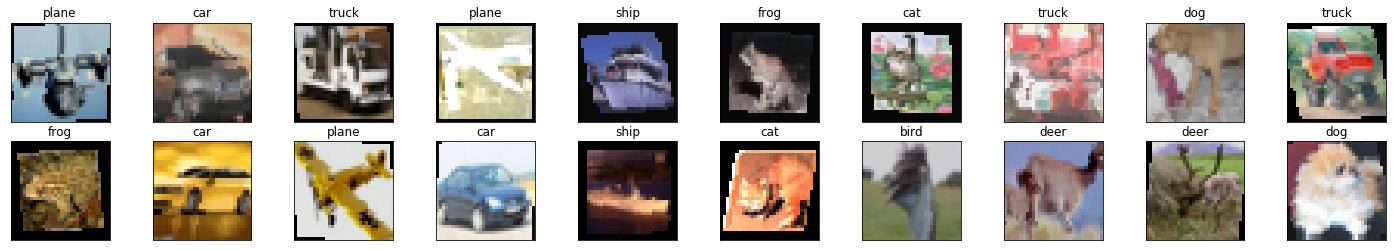

In [6]:
dataiter(training_loader)

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3 , 16 , 3  ,1 , padding = 1)
        self.conv2 = nn.Conv2d(16 , 32 , 3  ,1 , padding = 1)
        self.conv3 = nn.Conv2d(32 , 64 , 3  ,1 , padding = 1)
        self.fc1 = nn.Linear(4*4*64 , 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500 , 10)
    def forward(self , x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x , 2 , 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x , 2 , 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x , 2 , 2)
        x = x.view(-1 , 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [8]:
model = LeNet().to(device)
model


LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [26]:
class Conv_layervis(nn.Module):
    def __init__(self,layer,img):
        super(Conv_layervis , self).__init__()
         
        self.layer = layer
        self.img = img
        self.weights = self.layer.weight.data # Load the weights
        
        self.w = self.weights.cpu().numpy()
        
        self.fig = plt.figure(figsize = (30 , 10))

        self.columns = 5*2
        self.rows = 2

        for i in range(self.columns * self.rows):
            self.fig.add_subplot(self.rows , self.columns , i+1)
            if(i%2 == 0):
                plt.imshow(self.w[int(i/2)][0] , cmap = 'gray')
            else:
                self.c = cv2.filter2D(self.img , -1 , self.w[int((i-1)/2)][0])
                plt.imshow(self.c , cmap = 'gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Conv_layervis(
  (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

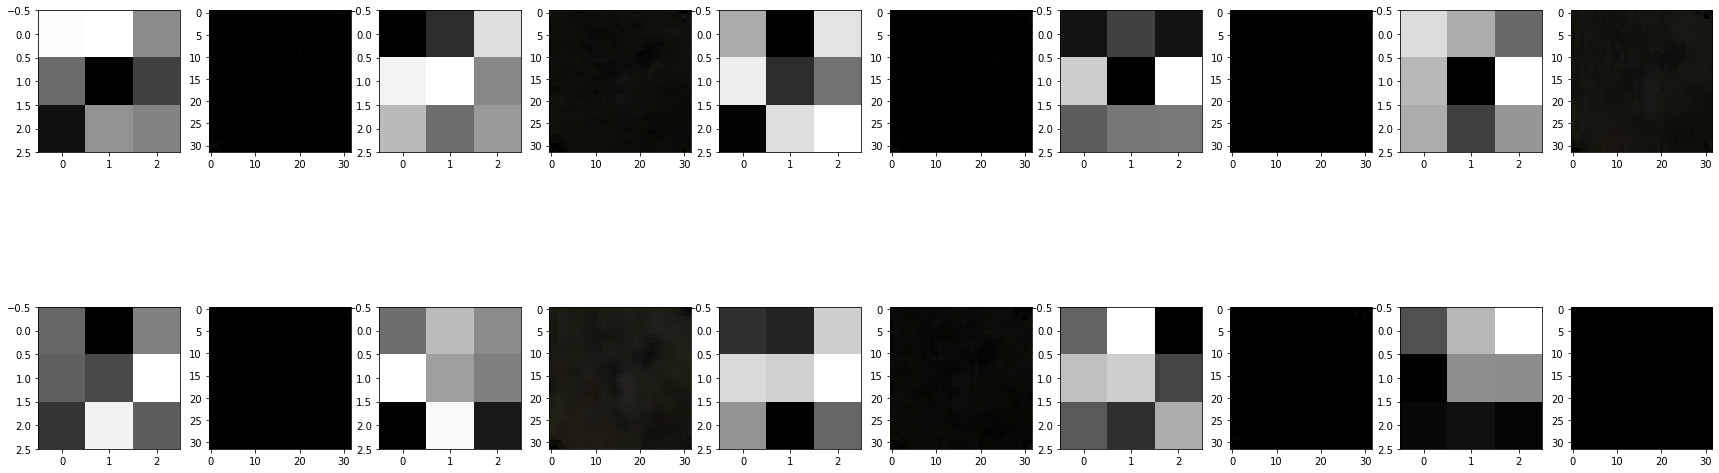

In [32]:
Conv_layervis(model.conv3 , im_convert(images[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Conv_layervis(
  (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

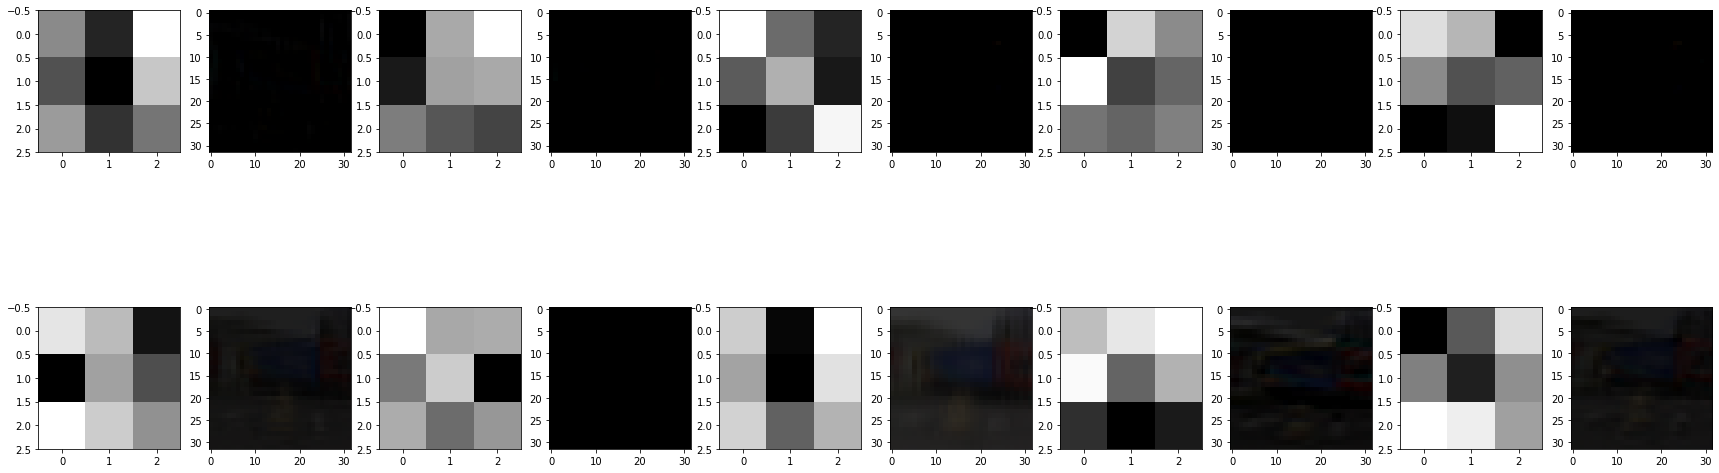

In [33]:
Conv_layervis(model.conv2 , im_convert(images[1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Conv_layervis(
  (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

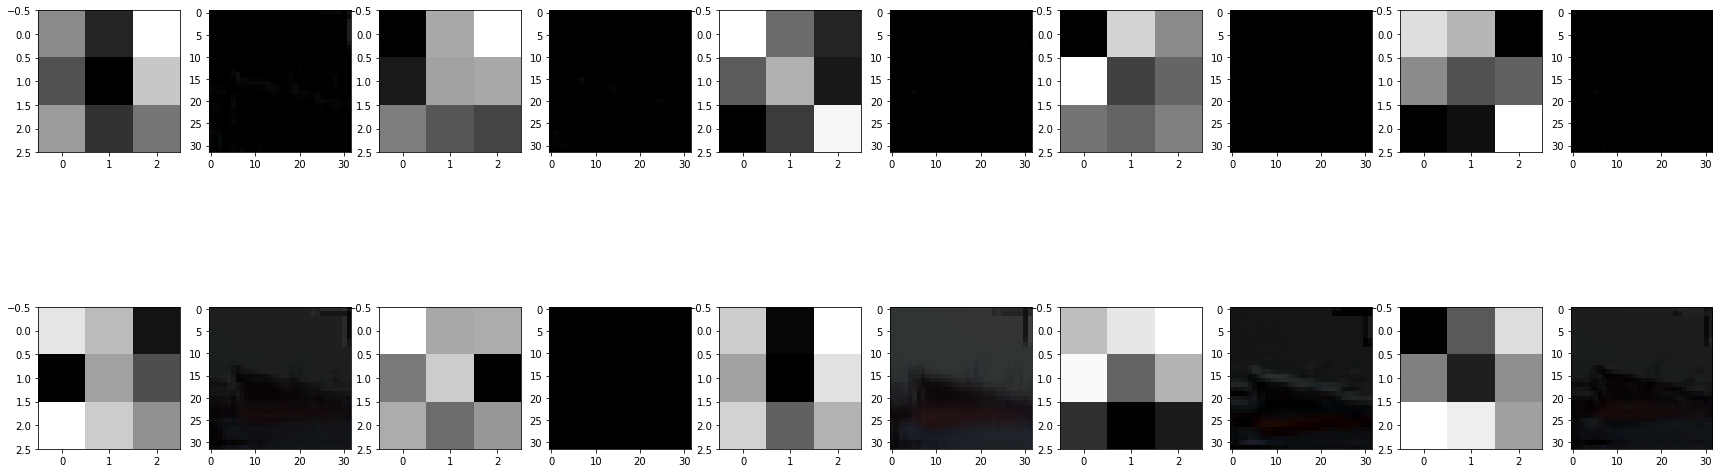

In [31]:
Conv_layervis(model.conv2 , im_convert(images[2]))

In [13]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.Adam(model.parameters() , lr = 0.0015) # Adam optimizer function with 0.001 learning rate


epoch : 1
training loss: 1.6531, acc 39.0620 
epoch : 2
training loss: 1.3540, acc 51.1140 
epoch : 3
training loss: 1.2257, acc 56.3620 
epoch : 4
training loss: 1.1469, acc 59.4000 
epoch : 5
training loss: 1.0857, acc 61.5800 
epoch : 6
training loss: 1.0404, acc 63.1100 
epoch : 7
training loss: 0.9975, acc 65.0540 
epoch : 8
training loss: 0.9816, acc 65.3520 
epoch : 9
training loss: 0.9506, acc 66.6380 
epoch : 10
training loss: 0.9292, acc 67.5760 
epoch : 11
training loss: 0.9075, acc 68.0240 
epoch : 12
training loss: 0.9026, acc 68.2160 
epoch : 13
training loss: 0.8858, acc 69.0900 
epoch : 14
training loss: 0.8758, acc 69.3200 
epoch : 15
training loss: 0.8687, acc 69.4300 
epoch : 16
training loss: 0.8601, acc 69.8600 
epoch : 17
training loss: 0.8442, acc 70.5140 
epoch : 18
training loss: 0.8425, acc 70.3960 
epoch : 19
training loss: 0.8341, acc 70.9680 
epoch : 20
training loss: 0.8267, acc 71.0780 
epoch : 21
training loss: 0.8196, acc 71.4380 
epoch : 22
training lo

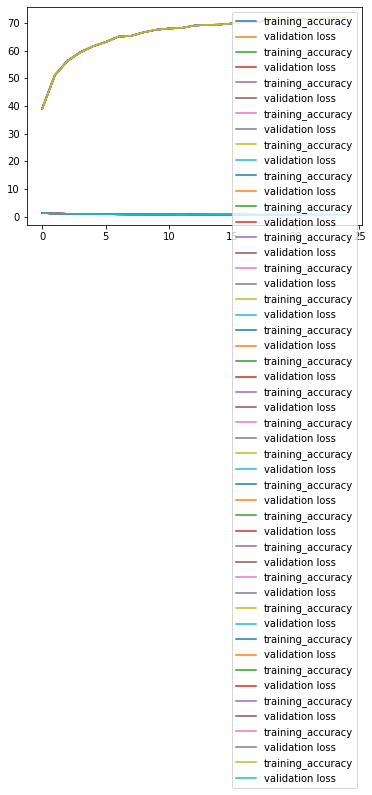

In [14]:
epochs = 25
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []
 
for e in range(epochs):
 
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
 
  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
   
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
   
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
 
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
       
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
     
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/ len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
   
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
   
    plt.plot(running_corrects_history , label = 'training_accuracy')
    plt.plot(val_running_loss_history, label='validation loss')
    plt.legend()

In [31]:
torch.save(model, 'model1.pkl') 

c:\users\srimanth tenneti\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [34]:
import torch.onnx

torch.onnx.export(model, inputs, "CIFAR10.onnx")

car


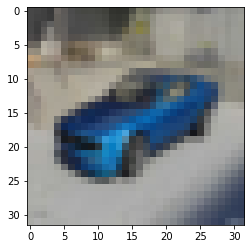

In [53]:
url = 'https://i.ytimg.com/vi/9YJh-vWX_6w/hqdefault.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

img = transform(img)
plt.imshow(im_convert(img))

image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

truck


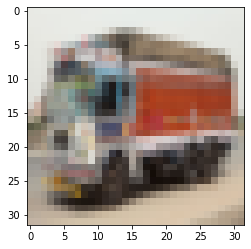

In [54]:
url = 'http://www.fubiz.net/wp-content/uploads/2014/12/Indian-Technicolor-Trucks-Photography-6.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

img = transform(img)
plt.imshow(im_convert(img))

image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

car


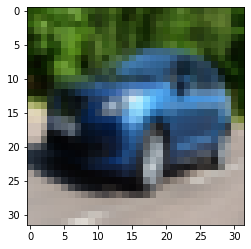

In [55]:
url = 'http://cdn2.autoexpress.co.uk/sites/autoexpressuk/files/2016/06/baleno-4.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

img = transform(img)
plt.imshow(im_convert(img))

image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

NameError: name 'model' is not defined

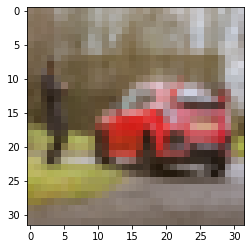

In [10]:
url = 'https://car-images.bauersecure.com/pagefiles/81193/honda_civic_type_r_94.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

img = transform(img)
plt.imshow(im_convert(img))

image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])